### **Step 1: Data Preparation and Exploratory Data Analysis**

#### **Importing of Libraries**

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
import lime
import lime.lime_tabular
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lime.lime_tabular import LimeTabularExplainer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import xgboost as xgb
import lightgbm as lgb
from IPython.display import display, Markdown

#### **Load the datasets**
The **data_batch** spreadsheet contain each batch produced by the site, expected yield and actual yield, as well as estimated cost of scrap in $.

The **data_fail** spreadsheet contains the data on all of the Quality Control and in-production fails (defined as a 100% loss or scrap).

In [64]:
batch_data = pd.read_csv('data_batch.csv')
fail_data = pd.read_csv('data_fail.csv')

#### **Check the number of rows and columns**

In [65]:
print(f'The number of rows in Batch Data: {batch_data.shape[0]}')
print(f'\nThe number of columns in Batch Data: {batch_data.shape[1]}')
print(f'\nThe number of rows in Fail Data: {fail_data.shape[0]}')
print(f'\nThe number of columns in Fail Data: {fail_data.shape[1]}')

The number of rows in Batch Data: 2171

The number of columns in Batch Data: 15

The number of rows in Fail Data: 269

The number of columns in Fail Data: 18


#### **Check for missing values in both datasets**

In [66]:
# Markdown is used to make the line bold while printing
display(Markdown("**Missing values in Batch Data:**"))
print(batch_data.isnull().sum())
display(Markdown("**Missing values in Fail Data:**"))
print(fail_data.isnull().sum())

**Missing values in Batch Data:**

Material                 2
Batch                    1
End Date                 2
Period                   2
Year                     2
U.O.M.                   2
Theoretical Yield        2
G.R.Qty                  2
Total Input in ML        2
QC Qty (ML)              2
Theoretical Yield(ML)    1
G.R.Qty(ML)              1
Waste in ML              1
% Waste loss             2
Waste Total Cost         1
dtype: int64


**Missing values in Fail Data:**

QC / In-Production Fail                              0
Plates / Bottles / Bond                              0
Product/Material                                     0
Batch Number                                         0
Internal Fail Date\n(SAP UD Date)                    0
Week No.                                             0
SAP Fail Category / Description                      0
Sub Category - Fails                                 0
Date of Manufacture                                  0
Week of Manufacture                                  0
Manufacturing Location                               2
Vessel                                              62
Order Quantity (Expected Yield)                      9
Total Quantity Produced (plate packs / bottles)    233
Cost Variance (Expected Yield v Actual)              9
Costing                                             10
SAP 'IN' Number                                      3
Additional Information                             269
dtype: int

**The above data give the below insights:**

*   The Batch Data is very complete and should provide reliable information for analysis.
*   The Fail Data has more missing values, particularly in the production quantity and additional information fields.
*   The missing vessel information in the Fail Data might limit some analyses related to equipment-specific issues.
*   The high number of missing values in Total Quantity Produced for failed batches might make it challenging to accurately calculate yield or loss for these cases.


#### **Create a correlation heatmap for batch data**


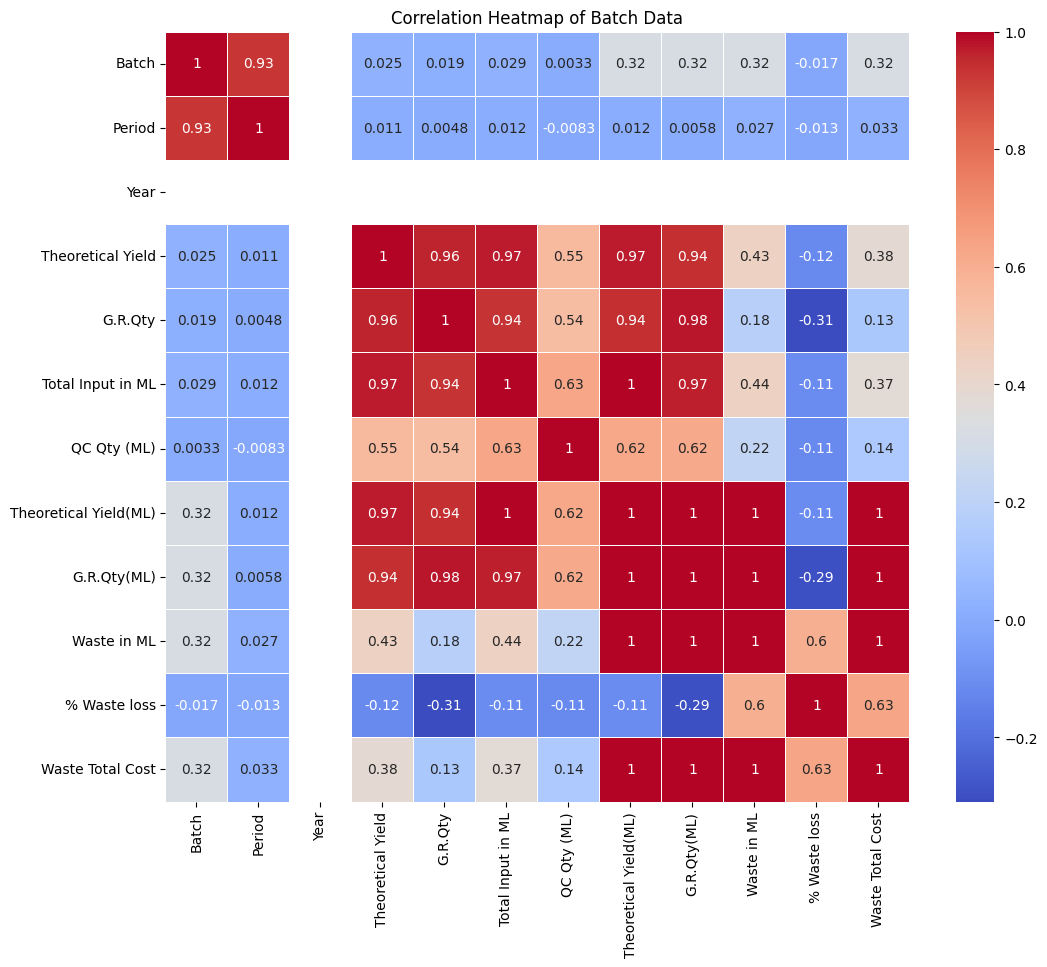

In [67]:
plt.figure(figsize=(12, 10))
# Select only numeric columns for correlation matrix
numeric_columns = batch_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = batch_data[numeric_columns].corr()
# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Batch Data')
plt.show()

**The key insights from this heatmap:**

**Strong correlations:**

**Batch and Period** are highly correlated (0.93), which is expected as they likely represent sequential production runs.
Theoretical Yield, G.R.Qty (actual yield), Total Input in ML, Theoretical Yield(ML), and G.R.Qty(ML) are all highly correlated with each other (0.94-1.00). This indicates a strong relationship between input, expected output, and actual output.

**Waste metrics:**

Waste in ML is perfectly correlated (1.0) with Theoretical Yield(ML), G.R.Qty(ML), and Waste Total Cost. This suggests that waste volume directly influences cost.
% Waste loss has a moderate positive correlation (0.6) with Waste in ML and Waste Total Cost, indicating that higher percentage waste corresponds to higher absolute waste and costs.

**Negative correlations:**

% Waste loss has weak to moderate negative correlations with Theoretical Yield, G.R.Qty, and Total Input in ML (-0.12 to -0.31). This suggests that larger batch sizes might lead to slightly lower percentage waste.

**QC Qty (ML):**

Has moderate positive correlations (0.54-0.63) with yield and input metrics, indicating that larger batches require more quality control samples.

**Waste Total Cost:**

Perfectly correlated with Theoretical Yield(ML), G.R.Qty(ML), and Waste in ML, suggesting that the cost calculation is directly based on these volumes.
Strong positive correlation (0.63) with % Waste loss, confirming that higher percentage waste leads to higher costs.

**Batch and Period:**

Have very weak correlations with most other variables, suggesting that waste and yield issues are not strongly tied to specific time periods or batch sequences.

**Year:**

Shows no significant correlations, possibly due to limited variation in the dataset if it covers only one year.

These insights suggest that while the production process is consistent (strong correlations between input and output), there are opportunities to reduce waste and costs by focusing on factors that influence the percentage of waste loss. The weak correlations with time-related variables (Batch, Period, Year) indicate that waste issues are more likely related to process or material factors rather than temporal trends.

**### Visualize the distribution of the target variable (Waste Total Cost)**

Waste Total Cost represents the cost of scrap material to the company

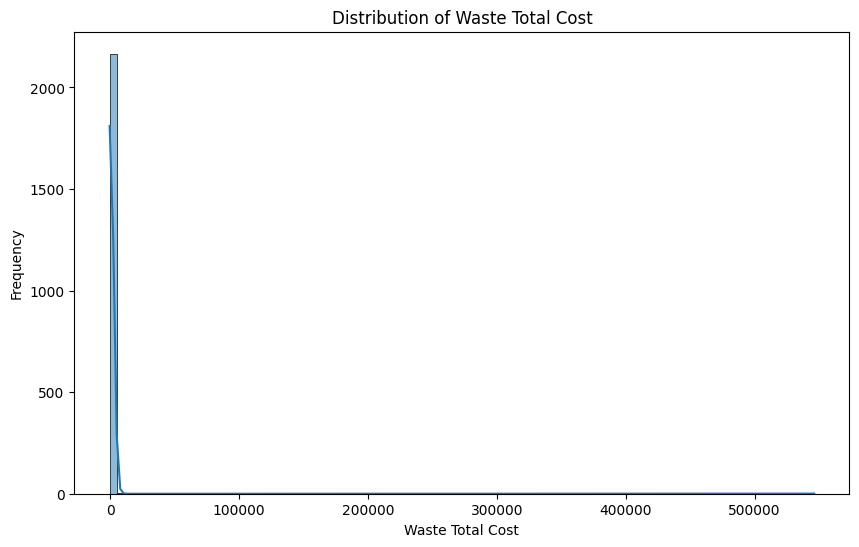

In [68]:
#histplots
plt.figure(figsize=(10, 6))
#Below line creates a histogram for the Waste Total Cost column with 5 bins. The kde=True parameter adds
#a kernel density estimate (KDE) line to the plot, which provides a smoothed estimate of the distribution.
sns.histplot(batch_data['Waste Total Cost'], bins=100, kde=True)
plt.title('Distribution of Waste Total Cost')
plt.xlabel('Waste Total Cost')
plt.ylabel('Frequency')
plt.show()

**Right-Skewed Distribution:** The distribution remains right-skewed, with a significant concentration of data points at the lower end of the Waste Total Cost spectrum and a long tail extending towards the higher end. This indicates that most observations have low waste costs, while a few have very high waste costs.

**Frequency Concentration:** The highest frequency of data points is still clustered around the lowest values of Waste Total Cost. The additional bins allow us to see that the majority of the data points are very close to zero, indicating that low waste costs are common.

**Outliers:** The histogram shows a few extreme values (outliers) with very high Waste Total Cost. These outliers can significantly impact the mean and variance of the dataset and might need further investigation to understand their causes.

**Data Granularity:** The increased number of bins provides a more granular view of the distribution, revealing more detail about the spread of the data. This helps in identifying patterns and understanding the distribution better.

**KDE Line:** The Kernel Density Estimate (KDE) line still shows a sharp peak at the start, confirming the high concentration of low waste costs. The line gradually tapers off, indicating the presence of fewer high-cost values.

The below code handles missing values in **`batch_data`** by imputing numeric columns with the median and categorical columns with the most frequent value.

In [69]:
# Handle missing values in Batch Data
numeric_columns = batch_data.select_dtypes(include=[np.number]).columns
categorical_columns = batch_data.select_dtypes(exclude=[np.number]).columns

In [70]:
# For numeric columns, impute with median
numeric_imputer = SimpleImputer(strategy='median')
batch_data[numeric_columns] = numeric_imputer.fit_transform(batch_data[numeric_columns])

In [71]:
# For categorical columns, impute with most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
batch_data[categorical_columns] = categorical_imputer.fit_transform(batch_data[categorical_columns])

This below block handles missing values in **`fail_data`** by converting relevant columns to numeric types and imputing missing values appropriately.

In [72]:
# Handle missing values in Fail Data
# Ensure the columns are numeric
fail_data['Order Quantity (Expected Yield)'] = pd.to_numeric(fail_data['Order Quantity (Expected Yield)'], errors='coerce')
fail_data['Total Quantity Produced (plate packs / bottles)'] = pd.to_numeric(fail_data['Total Quantity Produced (plate packs / bottles)'], errors='coerce')
fail_data['Cost Variance (Expected Yield v Actual)'] = pd.to_numeric(fail_data['Cost Variance (Expected Yield v Actual)'], errors='coerce')
fail_data['Costing'] = pd.to_numeric(fail_data['Costing'], errors='coerce')

fail_data['Manufacturing Location'].fillna(fail_data['Manufacturing Location'].mode()[0], inplace=True)
fail_data['Vessel'].fillna('Unknown', inplace=True)
fail_data['Order Quantity (Expected Yield)'].fillna(fail_data['Order Quantity (Expected Yield)'].median(), inplace=True)
fail_data['Total Quantity Produced (plate packs / bottles)'].fillna(fail_data['Total Quantity Produced (plate packs / bottles)'].median(), inplace=True)
fail_data['Cost Variance (Expected Yield v Actual)'].fillna(0, inplace=True)
fail_data['Costing'].fillna(fail_data['Costing'].median(), inplace=True)
fail_data['SAP \'IN\' Number'].fillna('Unknown', inplace=True)
fail_data['Additional Information'].fillna('No additional info', inplace=True)

In [73]:
# Verify that the corrections worked
print(fail_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 18 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   QC / In-Production Fail                          269 non-null    object 
 1   Plates / Bottles / Bond                          269 non-null    object 
 2   Product/Material                                 269 non-null    object 
 3   Batch Number                                     269 non-null    int64  
 4   Internal Fail Date
(SAP UD Date)                 269 non-null    object 
 5   Week No.                                         269 non-null    int64  
 6   SAP Fail Category / Description                  269 non-null    object 
 7   Sub Category - Fails                             269 non-null    object 
 8   Date of Manufacture                              269 non-null    object 
 9   Week of Manufacture             

### Step 2. Feature Engineering

This block creates new features `Yield_Efficiency` and `Waste_Percentage` in `batch_data`.

In [74]:
# Feature Engineering
batch_data['Yield_Efficiency'] = batch_data['G.R.Qty'] / batch_data['Theoretical Yield']
batch_data['Waste_Percentage'] = batch_data['Waste in ML'] / batch_data['Total Input in ML'] * 100

This below block merges `batch_data` and `fail_data`, handles NaN values, creates a binary `Failed` column, drops unnecessary columns, and prints summary statistics.

In [75]:
# Merge the datasets
merged_data = pd.merge(batch_data, fail_data, left_on=['Material', 'Batch'], right_on=['Product/Material', 'Batch Number'], how='left')

In [76]:
print(f'The number of rows in Merged Dataset: {merged_data.shape[0]}')
print(f'\nThe number of columns in Merged Dataset: {merged_data.shape[1]}')

The number of rows in Merged Dataset: 2171

The number of columns in Merged Dataset: 35


In [77]:
# Handle NaN values more appropriately
for col in fail_data.columns:
    if col in merged_data.columns:
        if merged_data[col].dtype == 'object':
            # For categorical columns, use 'No Fail' or another appropriate indicator
            merged_data[col].fillna('No Fail', inplace=True)
        elif merged_data[col].dtype in ['int64', 'float64']:
            # For numerical columns, use 0 or the median/mean depending on the nature of the data
            merged_data[col].fillna(0, inplace=True)

# Create a binary column to indicate if a batch failed
merged_data['Failed'] = merged_data['Product/Material'].notna().astype(int)

# Drop columns that are no longer needed after the merge
merged_data.drop(['Product/Material', 'Batch Number'], axis=1, inplace=True)

# Display the first few rows of the merged data
print(merged_data.head())

  Material      Batch    End Date  Period    Year U.O.M.  Theoretical Yield  \
0  JM1441K  6885243.0  05/01/2024     1.0  2024.0    PLT           1865.131   
1  JM1441K  6885253.0  05/01/2024     1.0  2024.0    PLT           1865.131   
2  GU2783J  6885263.0  05/01/2024     1.0  2024.0    PLT           1080.187   
3  ON0348A  6885273.0  05/01/2024     1.0  2024.0    PLT            969.895   
4  CT1716F  6885283.0  05/01/2024     1.0  2024.0    PLT            908.957   

   G.R.Qty  Total Input in ML  QC Qty (ML)  ...  Week of Manufacture  \
0   1712.0          337163.49       1440.0  ...                  0.0   
1   1695.0          337163.49       1440.0  ...                  0.0   
2    998.0          196413.60       1980.0  ...                  0.0   
3    928.0          175841.16       1260.0  ...                  0.0   
4    830.0          163738.20        126.0  ...                  0.0   

   Manufacturing Location   Vessel  Order Quantity (Expected Yield)  \
0                 No 

In [78]:
# Check for any remaining NaN values
print(merged_data.isnull().sum())

Material                                           0
Batch                                              0
End Date                                           0
Period                                             0
Year                                               0
U.O.M.                                             0
Theoretical Yield                                  0
G.R.Qty                                            0
Total Input in ML                                  0
QC Qty (ML)                                        0
Theoretical Yield(ML)                              0
G.R.Qty(ML)                                        0
Waste in ML                                        0
% Waste loss                                       0
Waste Total Cost                                   0
Yield_Efficiency                                   0
Waste_Percentage                                   0
QC / In-Production Fail                            0
Plates / Bottles / Bond                       

In [79]:
# Inspect the data
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2171 entries, 0 to 2170
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Material                                         2171 non-null   object 
 1   Batch                                            2171 non-null   float64
 2   End Date                                         2171 non-null   object 
 3   Period                                           2171 non-null   float64
 4   Year                                             2171 non-null   float64
 5   U.O.M.                                           2171 non-null   object 
 6   Theoretical Yield                                2171 non-null   float64
 7   G.R.Qty                                          2171 non-null   float64
 8   Total Input in ML                                2171 non-null   float64
 9   QC Qty (ML)                   

In [80]:
print(merged_data.describe())

              Batch       Period    Year  Theoretical Yield      G.R.Qty  \
count  2.171000e+03  2171.000000  2171.0        2171.000000  2171.000000   
mean   6.896128e+06     1.802856  2024.0         663.769213   582.491018   
std    6.595677e+03     0.785708     0.0         566.142766   521.284349   
min    6.885243e+06     1.000000  2024.0          33.356000     0.000000   
25%    6.890668e+06     1.000000  2024.0         140.326000   129.000000   
50%    6.896088e+06     2.000000  2024.0         419.823000   339.000000   
75%    6.901508e+06     2.000000  2024.0         944.314000   885.500000   
max    6.992886e+06     3.000000  2024.0        2433.303000  2400.000000   

       Total Input in ML  QC Qty (ML)  Theoretical Yield(ML)   G.R.Qty(ML)  \
count        2171.000000  2171.000000           2.171000e+03  2.171000e+03   
mean       129168.291639   470.637356           2.572444e+05  2.257329e+05   
std        114266.624144   648.979402           5.990171e+06  5.256598e+06   
min

**Box Plot of Waste Total Cost by Failure Status**

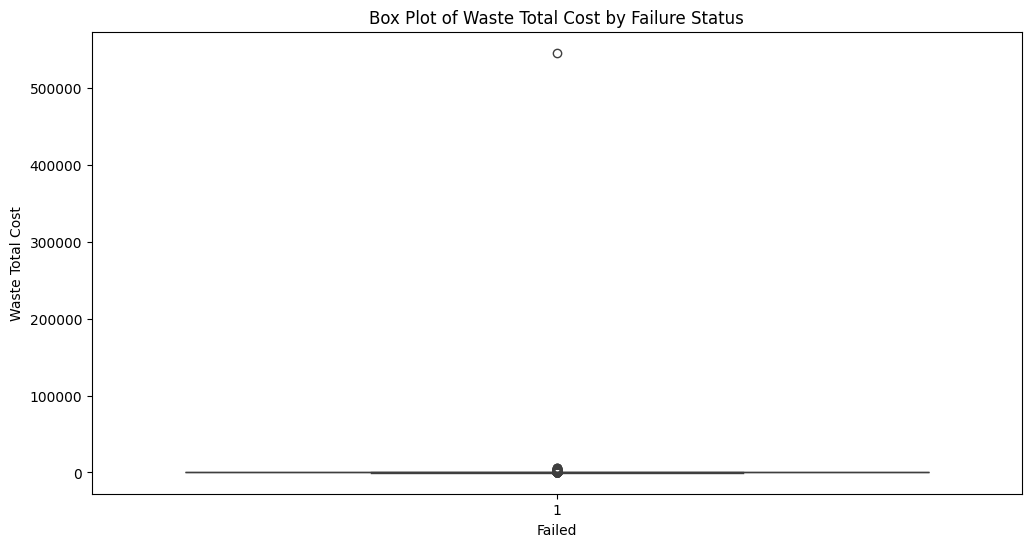

In [81]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Failed', y='Waste Total Cost', data=merged_data)
plt.title('Box Plot of Waste Total Cost by Failure Status')
plt.xlabel('Failed')
plt.ylabel('Waste Total Cost')
plt.show()

**High Outliers:** There are a few batches with exceptionally high waste costs among the failed batches.

**Low Median:** The typical waste cost for failed batches is low, indicating that high costs are not common.

**Tight Clustering:** Most failed batches have similar Waste Total Cost values, as shown by the small IQR.

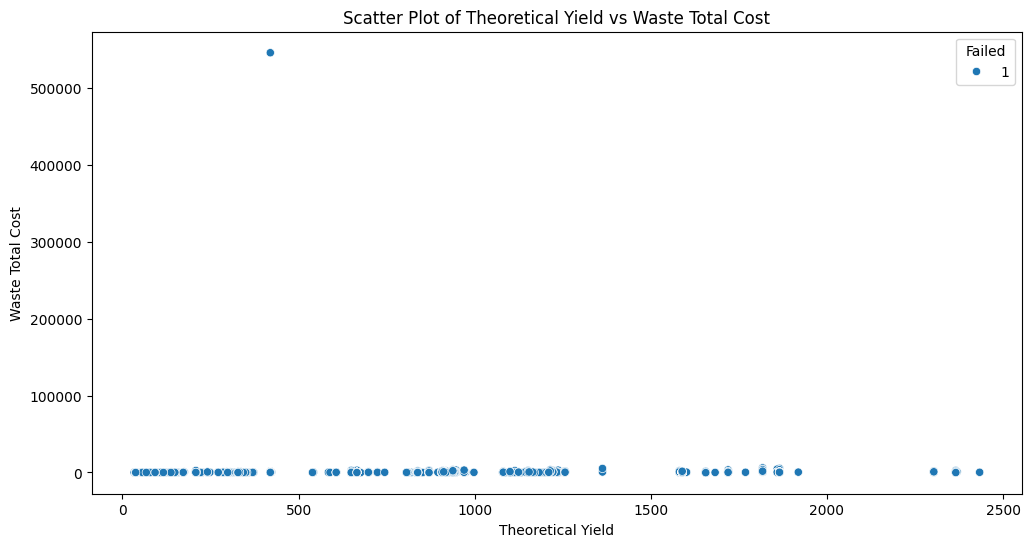

In [82]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Theoretical Yield', y='Waste Total Cost', hue='Failed', data=merged_data)
plt.title('Scatter Plot of Theoretical Yield vs Waste Total Cost')
plt.xlabel('Theoretical Yield')
plt.ylabel('Waste Total Cost')
plt.show()

**High Outlier:** There is an exceptional batch with a very high waste cost that needs to be investigated to understand the cause of such high wastage.

**Low Waste Costs:** The majority of batches have low waste costs, which is a positive indicator of the production process efficiency.

**Concentration of Theoretical Yield:** Most batches have theoretical yields below 1500, which may suggest a common production scale or capacity limit.

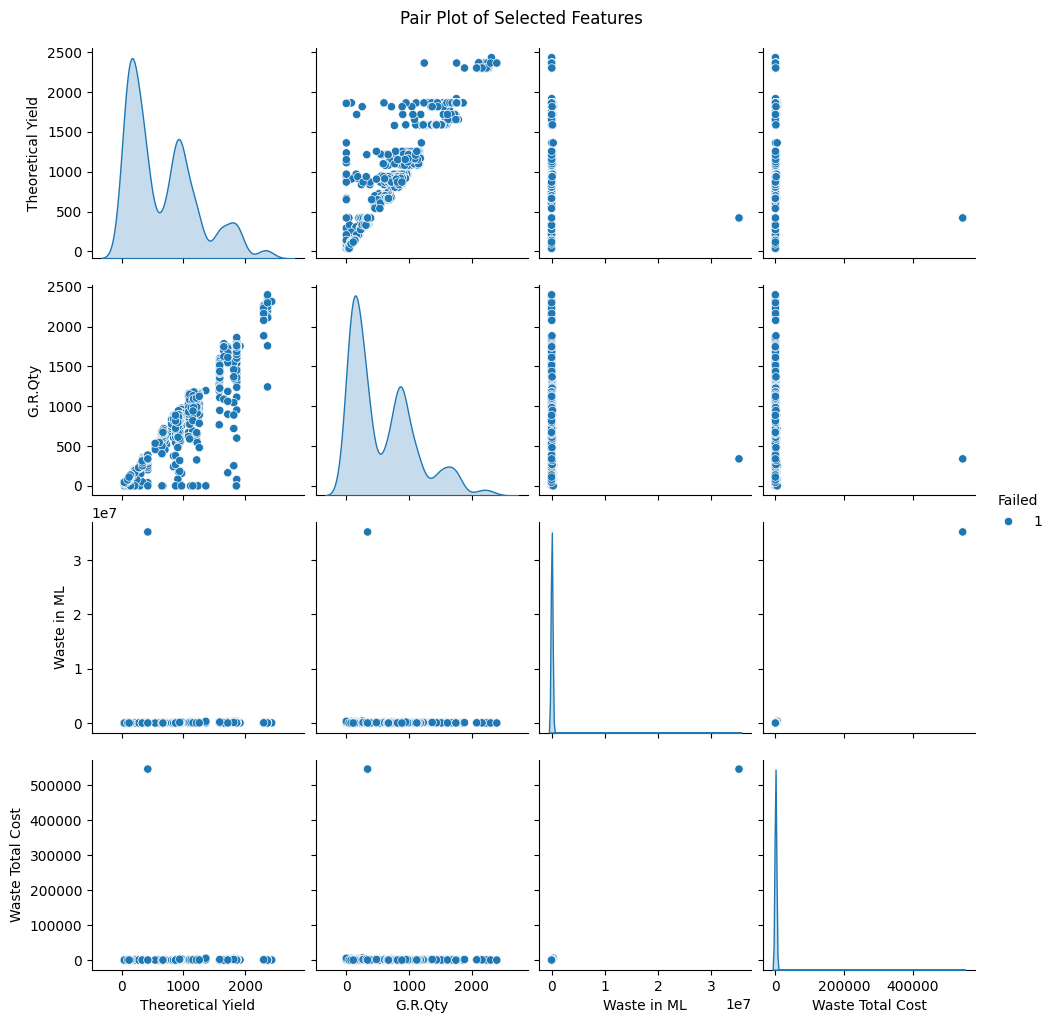

In [83]:
sns.pairplot(merged_data[['Theoretical Yield', 'G.R.Qty', 'Waste in ML', 'Waste Total Cost', 'Failed']], hue='Failed')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

**Correlation Between Yield and Gross Quantity:** There is a strong correlation between theoretical yield and gross quantity, which is expected in most production processes.

**Low Waste Costs:** Most batches have low waste costs, but the presence of an outlier indicates that some batches can incur extremely high waste costs.

**Skewed Distributions:** Waste-related features have skewed distributions with most values near zero, indicating that waste events are relatively rare but can be severe when they do occur.

**Multimodal Yield Distribution:** Theoretical yield has a multimodal distribution, suggesting different production processes or batch sizes.

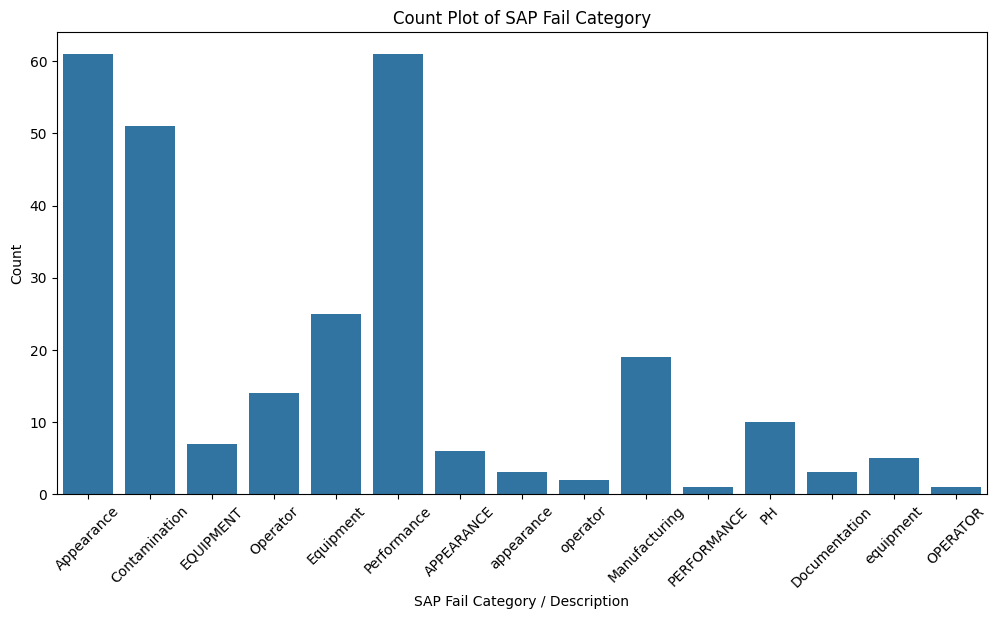

In [84]:
plt.figure(figsize=(12, 6))
sns.countplot(x='SAP Fail Category / Description', data=fail_data)
plt.title('Count Plot of SAP Fail Category')
plt.xlabel('SAP Fail Category / Description')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The above plot shows duplicate categories. Let's correct the same.

In [85]:
def standardize_values(value):
    if isinstance(value, str):
        return value.lower().strip().capitalize()
    return value

# Load the datasets
batch_data = pd.read_csv('data_batch.csv')
fail_data = pd.read_csv('data_fail.csv')

# Columns to standardize
columns_to_standardize = [
    'SAP Fail Category / Description',
    'Sub Category - Fails',
    'Manufacturing Location',
    'Vessel',
    'Material'
]

# Standardize values in specific columns
for col in columns_to_standardize:
    if col in batch_data.columns:
        batch_data[col] = batch_data[col].apply(standardize_values)
    if col in fail_data.columns:
        fail_data[col] = fail_data[col].apply(standardize_values)

# Specific standardization for 'SAP Fail Category / Description'
if 'SAP Fail Category / Description' in fail_data.columns:
    fail_data['SAP Fail Category / Description'] = fail_data['SAP Fail Category / Description'].replace({
        'Equipment': 'Equipment',
        'EQUIPMENT': 'Equipment',
        'equipment': 'Equipment',
        'Appearance': 'Appearance',
        'APPEARANCE': 'Appearance',
        'Performance': 'Performance',
        'performance': 'Performance',
        'PERFORMANCE': 'Performance',
        'Contamination': 'Contamination',
        'Manufacturing': 'Manufacturing',
        'Operator': 'Operator',
        'operator': 'Operator',
        'OPERATOR': 'Operator',
        'Ph': 'PH',
        'Documentation': 'Documentation'
    })

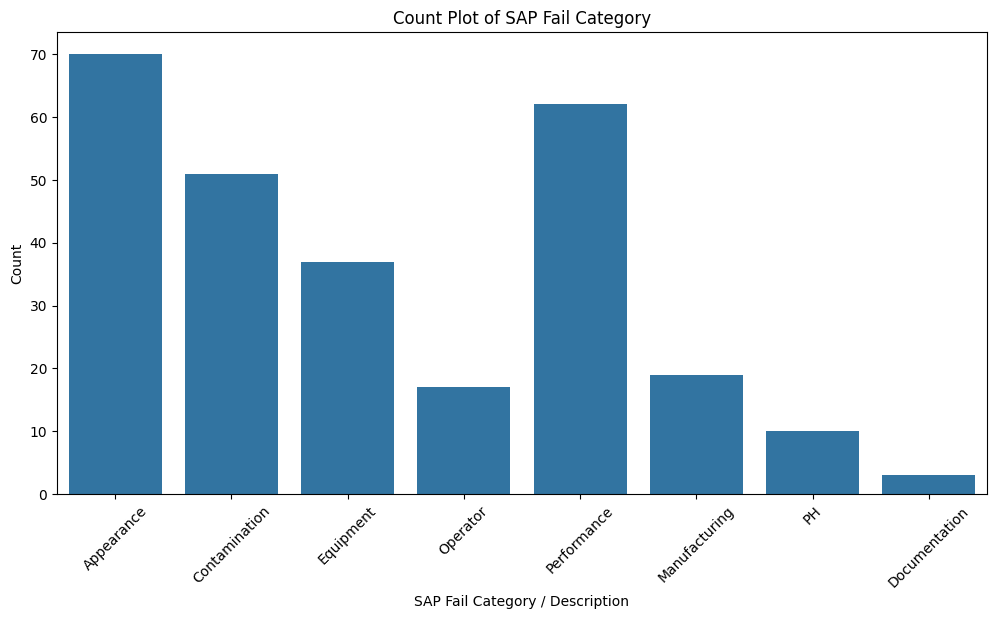

In [86]:
plt.figure(figsize=(12, 6))
sns.countplot(x='SAP Fail Category / Description', data=fail_data)
plt.title('Count Plot of SAP Fail Category')
plt.xlabel('SAP Fail Category / Description')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The above is a count plot of SAP Fail Categories, providing insights into the frequency of different types of failures in a manufacturing or production process. Here are the key insights from this visualization:

**Most Common Fail Categories:**

Appearance is the most frequent fail category with about 70 occurrences.
Performance is the second most common, with around 62 instances.
Contamination is the third, with approximately 51 cases.


**Mid-range Fail Categories:**

Equipment-related fails are moderately common, with about 37 instances.
Manufacturing issues occur around 19 times.


**Less Frequent Fail Categories:**

Operator-related fails are less common, with about 17 occurrences.
PH (likely referring to pH level issues) appears about 10 times.
Documentation is the least frequent category, with only 3 instances.


**Distribution:**

There's a clear disparity between the most common and least common fail categories.
The top three categories (Appearance, Performance, Contamination) account for a significant majority of all failures.


**Process Implications:**

Quality control processes might need more focus on appearance-related issues.
Performance and contamination are also major areas of concern that may require attention.
While equipment issues are significant, they're not the leading cause of failures.


**Potential Areas for Improvement:**

Addressing appearance, performance, and contamination issues could potentially reduce over half of all failures.
Operator training and documentation processes seem to be working relatively well, given their lower frequency.

Further Analysis Needed:

It would be beneficial to investigate why appearance issues are so prevalent.
Understanding the specific nature of performance and contamination failures could lead to targeted solutions.

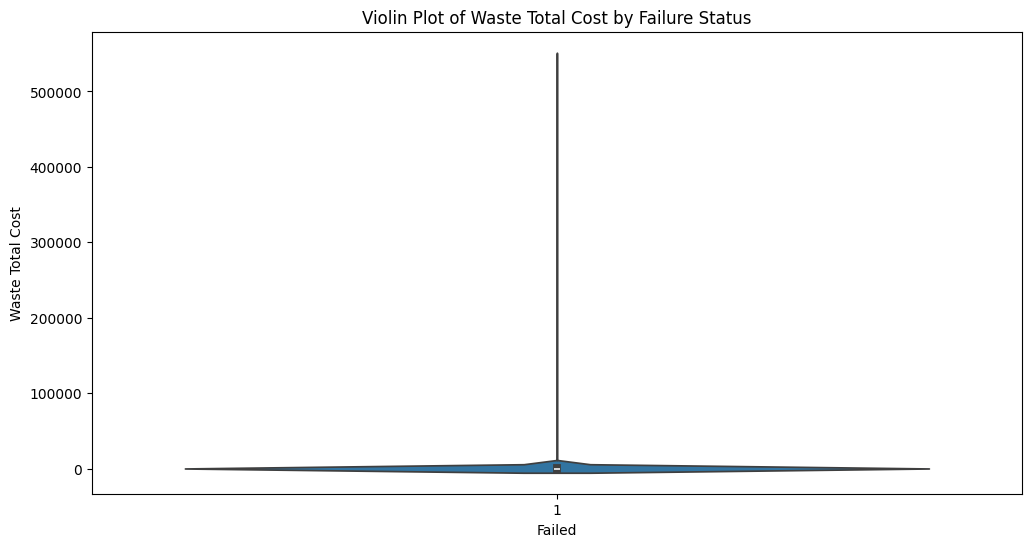

In [87]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Failed', y='Waste Total Cost', data=merged_data)
plt.title('Violin Plot of Waste Total Cost by Failure Status')
plt.xlabel('Failed')
plt.ylabel('Waste Total Cost')
plt.show()

This image shows a **violin plot of Waste Total Cost by Failure Status.** Here are the key insights from this visualization:

Distribution Shape:
The plot has a distinctive shape, with a very narrow "body" and a long, thin "tail" extending upwards. This indicates a highly skewed distribution of waste costs.

Concentration of Data:The majority of the data points are clustered at the bottom of the plot, suggesting that most failures result in relatively low waste costs.

Outliers: There's a significant outlier or group of outliers represented by the long, thin tail extending to around 500,000 on the y-axis. This indicates that while most failures have low costs, there are some extremely expensive failures.

Median Cost: The thickest part of the plot, near the bottom, likely represents the median waste cost, which appears to be quite low compared to the maximum.
Cost Range: The waste total cost ranges from near zero to approximately 500,000 units (presumably currency units, like dollars).

Failure Status: The x-axis shows only one category, "Failed", suggesting this plot is focusing solely on cases where a failure occurred.

Data Density: The width of the plot at different points indicates the frequency of data points at those cost levels. The plot is widest at the bottom, confirming that low-cost failures are most common.

Bimodal Distribution: There's a slight widening in the middle of the plot, which could indicate a secondary, smaller peak in the distribution of costs.

Potential for Further Analysis: This plot suggests that while most failures are manageable in terms of cost, there are rare but extremely costly failures that warrant investigation.

Risk Management Implications: The presence of high-cost outliers suggests a need for risk management strategies to mitigate the impact of these rare but significant events.

Data Quality: The plot appears to be based on a large number of data points, giving confidence in the reliability of the distribution shown.

In summary, this violin plot reveals that while most failures result in relatively low waste costs, there are occasional extremely costly failures. This information could be valuable for prioritizing quality improvement efforts and risk management strategies in the production process.

This below block creates and displays a correlation heatmap for numeric columns in `merged_data` after preprocessing.

Text(0.5, 1.0, 'Correlation Heatmap After Preprocessing')

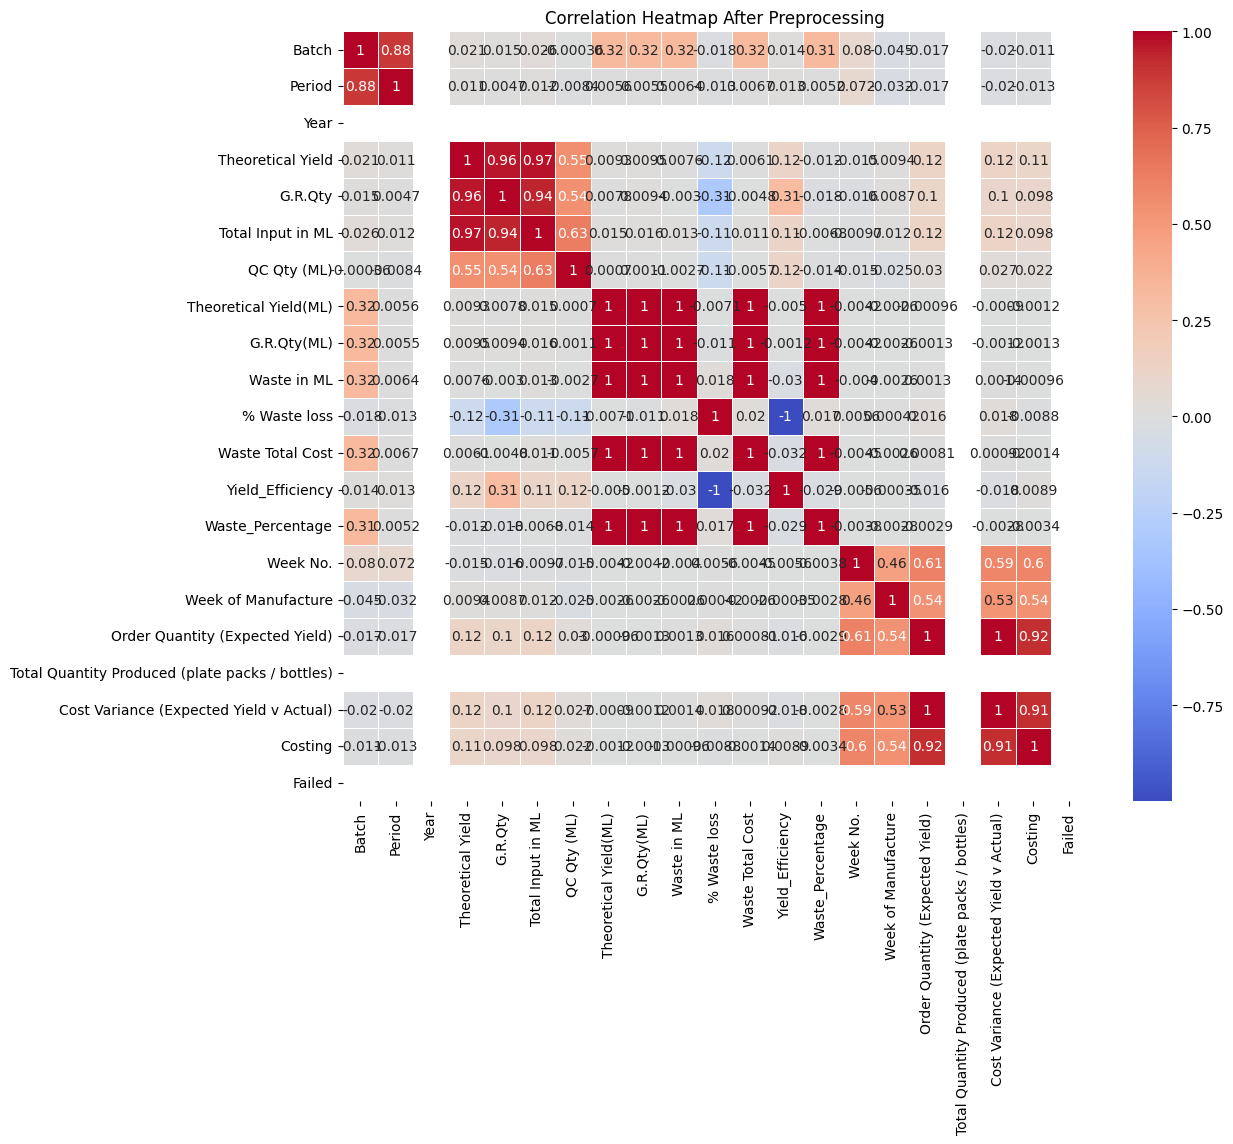

In [88]:
# Check correlations after preprocessing
plt.figure(figsize=(12, 10))
numeric_columns = merged_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = merged_data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap After Preprocessing')

This block selects the features and target variable for the model.

In [89]:
# Select features and target
features = ['Theoretical Yield', 'G.R.Qty', 'QC Qty (ML)', 'Waste in ML', '% Waste loss',
            'Yield_Efficiency', 'Waste_Percentage', 'Failed']
target = 'Waste Total Cost'

X = merged_data[features]
y = merged_data[target]

In [90]:
X = merged_data[features]
y = merged_data[target]

This block applies polynomial feature transformation to the feature set. The features are then scaled and the target variable is transformed to handle outliers and ensure normal distribution.

In [91]:
# Apply PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)

# Create new dataframe with polynomial features
X_new = pd.DataFrame(X_poly, columns=feature_names)

# Handle outliers and scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_new)
X_scaled = pd.DataFrame(X_scaled, columns=X_new.columns)

# Transform the target variable
pt = PowerTransformer(method='yeo-johnson', standardize=True)
y_transformed = pt.fit_transform(y.values.reshape(-1, 1)).ravel()

Data is split into training and test sets.

In [92]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_transformed, test_size=0.2, random_state=42)

This below block applies Recursive Feature Elimination (RFE) for feature selection using a RandomForestRegressor.

In [93]:
# Feature selection
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=20)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)

### Step 3: Model Development

The below block defines and trains a stacking regressor model using RandomForest, GradientBoosting, XGBoost, and LightGBM as base models and MLPRegressor as the meta-model. Predictions are made on the test set. We will apply the model on the datasets with outliers and after outlier removal from the data.

In [94]:
# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

In [95]:
# Define meta-model
meta_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Create stacking regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit stacking regressor
stacking_regressor.fit(X_train_selected, y_train)

# Make predictions
y_pred = stacking_regressor.predict(X_test_selected)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1736, number of used features: 20
[LightGBM] [Info] Start training from score -0.014893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 20
[LightGBM] [Info] Start training from score 0.001122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1389, number of used features: 20
[LightGBM] [Info] Start train

### Step 4 & 5: Evaluation and Iteration

The below code evaluates the stacking regressor model using mean squared error and R-squared metrics, performs cross-validation.

In [96]:
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Stacking Regressor - MSE: {mse}, R2: {r2}")

# Cross-validation
cv_scores = cross_val_score(stacking_regressor, X_scaled, y_transformed, cv=5, scoring='r2')
print(f"Cross-validation R2 scores: {cv_scores}")
print(f"Mean CV R2 score: {np.mean(cv_scores)}")

Stacking Regressor - MSE: 2.4017275346879488, R2: 0.21898671943590742
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 1736, number of used features: 42
[LightGBM] [Info] Start training from score -0.000601
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9729
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 42
[LightGBM] [Info] Start training from score 0.010529
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightG

The below code identifies the top 10 important features using RandomForestRegressor.

In [97]:
# Feature importance (using RandomForestRegressor as an example)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)
importance = rf.feature_importances_
feature_importance = pd.DataFrame({'feature': X_train.columns[rfe.support_], 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("Top 10 important features:")
print(feature_importance.head(10))

Top 10 important features:
                               feature  importance
4       Theoretical Yield % Waste loss    0.384168
7                 G.R.Qty % Waste loss    0.335709
5   Theoretical Yield Waste_Percentage    0.061992
13            Waste in ML % Waste loss    0.028982
9             QC Qty (ML) % Waste loss    0.026321
6                  G.R.Qty QC Qty (ML)    0.019119
10        QC Qty (ML) Yield_Efficiency    0.017867
11        QC Qty (ML) Waste_Percentage    0.013093
16       % Waste loss Yield_Efficiency    0.012505
19                  Waste_Percentage^2    0.012155


The below block plots the actual vs. predicted values in both transformed and original scales and calculates the performance metrics in the original scale.

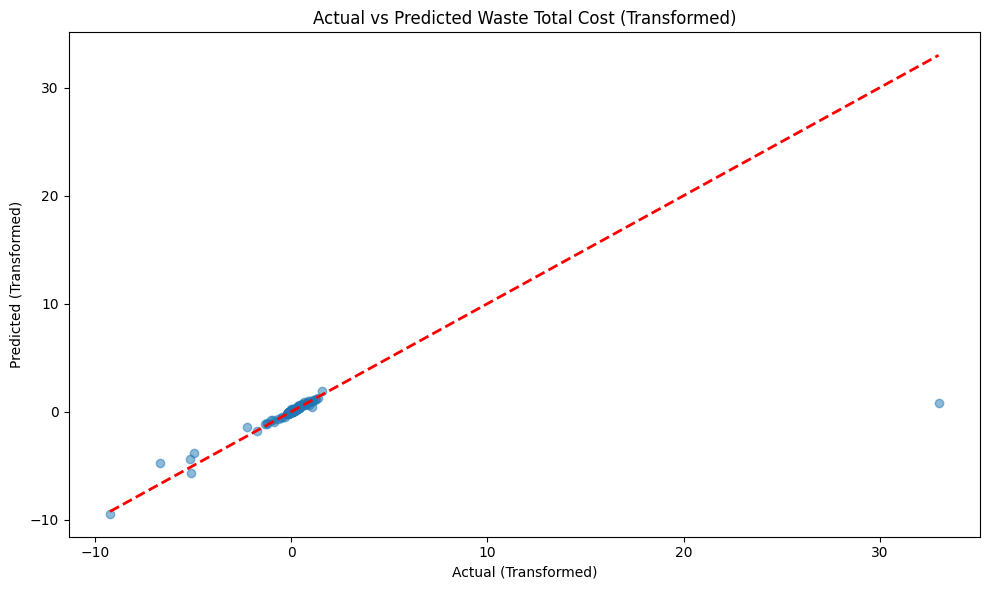

In [98]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual (Transformed)')
plt.ylabel('Predicted (Transformed)')
plt.title('Actual vs Predicted Waste Total Cost (Transformed)')
plt.tight_layout()
plt.show()

In [99]:
# Inverse transform predictions and actual values for interpretability
y_pred_original = pt.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_test_original = pt.inverse_transform(y_test.reshape(-1, 1)).ravel()

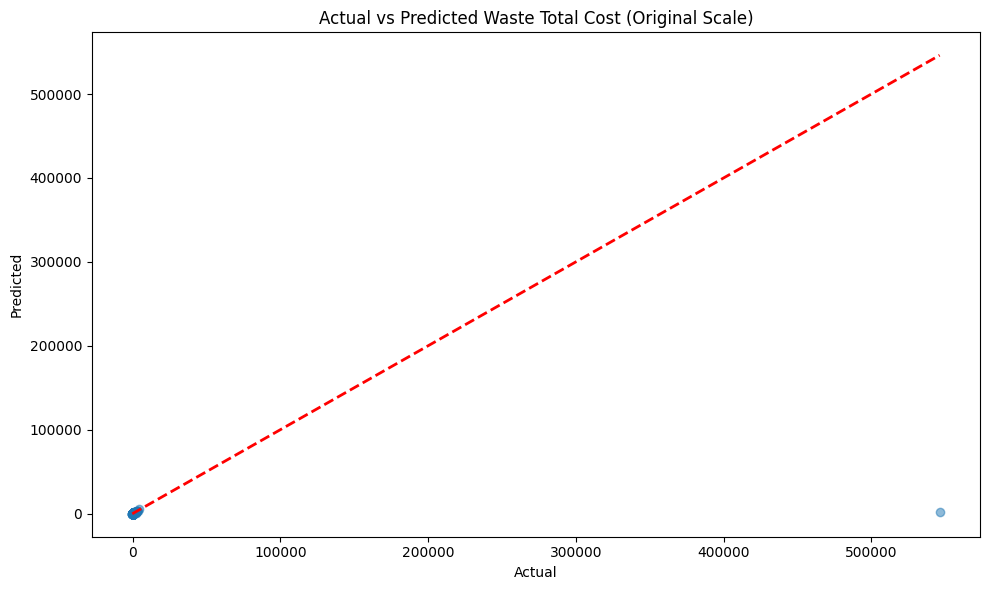

In [100]:
# Plot actual vs predicted values in original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Waste Total Cost (Original Scale)')
plt.tight_layout()
plt.show()

In [101]:
# Calculate MSE and R2 in original scale
mse_original = mean_squared_error(y_test_original, y_pred_original)
r2_original = r2_score(y_test_original, y_pred_original)
print(f"MSE (Original Scale): {mse_original}")
print(f"R2 (Original Scale): {r2_original}")

MSE (Original Scale): 681782386.5131766
R2 (Original Scale): 0.0031187631223814627


This block removes outliers, re-evaluates the model, plots the actual vs. predicted values, and calculates the performance metrics after **outlier removal**.

In [102]:
import numpy as np
from scipy import stats

# Function to remove outliers
def remove_outliers(X, y, z_threshold=3):
    z_scores = np.abs(stats.zscore(y))
    mask = z_scores < z_threshold
    return X[mask], y[mask]

# Remove outliers
X_cleaned, y_cleaned = remove_outliers(X_scaled, y_transformed)

print(f"Original data shape: {X_scaled.shape}")
print(f"Cleaned data shape: {X_cleaned.shape}")

# Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Feature selection
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=20)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)

# Retrain the stacking regressor
stacking_regressor.fit(X_train_selected, y_train)

# Make predictions
y_pred = stacking_regressor.predict(X_test_selected)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Stacking Regressor (after outlier removal) - MSE: {mse}, R2: {r2}")

Original data shape: (2171, 44)
Cleaned data shape: (2147, 44)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1717, number of used features: 20
[LightGBM] [Info] Start training from score 0.039707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1373, number of used features: 20
[LightGBM] [Info] Start training from score 0.035795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1

In [103]:
# Cross-validation
cv_scores = cross_val_score(stacking_regressor, X_cleaned, y_cleaned, cv=5, scoring='r2')
print(f"Cross-validation R2 scores: {cv_scores}")
print(f"Mean CV R2 score: {np.mean(cv_scores)}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 1717, number of used features: 42
[LightGBM] [Info] Start training from score 0.038198
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9733
[LightGBM] [Info] Number of data points in the train set: 1373, number of used features: 42
[LightGBM] [Info] Start training from score 0.037118
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

In [104]:
# Feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)
importance = rf.feature_importances_
feature_importance = pd.DataFrame({'feature': X_train.columns[rfe.support_], 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("Top 10 important features:")
print(feature_importance.head(10))

Top 10 important features:
                               feature  importance
3       Theoretical Yield % Waste loss    0.444266
6                 G.R.Qty % Waste loss    0.272588
4   Theoretical Yield Waste_Percentage    0.163086
13            Waste in ML % Waste loss    0.022958
15        Waste in ML Waste_Percentage    0.019018
12                       Waste in ML^2    0.010624
0                          Waste in ML    0.010388
7             G.R.Qty Waste_Percentage    0.009053
16                  Waste in ML Failed    0.008984
14        Waste in ML Yield_Efficiency    0.005097


In [105]:
#!pip install lime

#### **LIME Explanation of the Prediction**

LIME (Local Interpretable Model-agnostic Explanations) explains the prediction of the stacking regressor for a specific instance.

In [106]:
# Create the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_selected,
    feature_names=X_cleaned.columns,
    class_names=['Waste Total Cost'],
    mode='regression'
)

# Select a random instance from the test set for explanation
i = np.random.randint(0, X_test_selected.shape[0])
exp = explainer.explain_instance(
    data_row=X_test_selected[i],
    predict_fn=stacking_regressor.predict
)

# Print the explanation
print('Instance to be explained:', X_test_selected[i])
print('Actual value:', y_test[i])
print('Predicted value:', stacking_regressor.predict([X_test_selected[i]])[0])
exp.show_in_notebook(show_table=True)

#save the explanation to an HTML file:
#exp.save_to_file('lime_explanation.html')


Instance to be explained: [-0.06560584 -1.81634954 -0.19891207 -0.01344157 -0.02716858 -0.27169341
 -0.11610552 -0.14113363 -0.12048226  0.31772551 -0.3060771   0.30740071
 -0.0467996   0.72293951 -0.17381265  0.7294458  -0.06560584  1.4011008
  1.39424681 -1.81634954]
Actual value: 0.08719781643236425
Predicted value: 0.04153582629329797


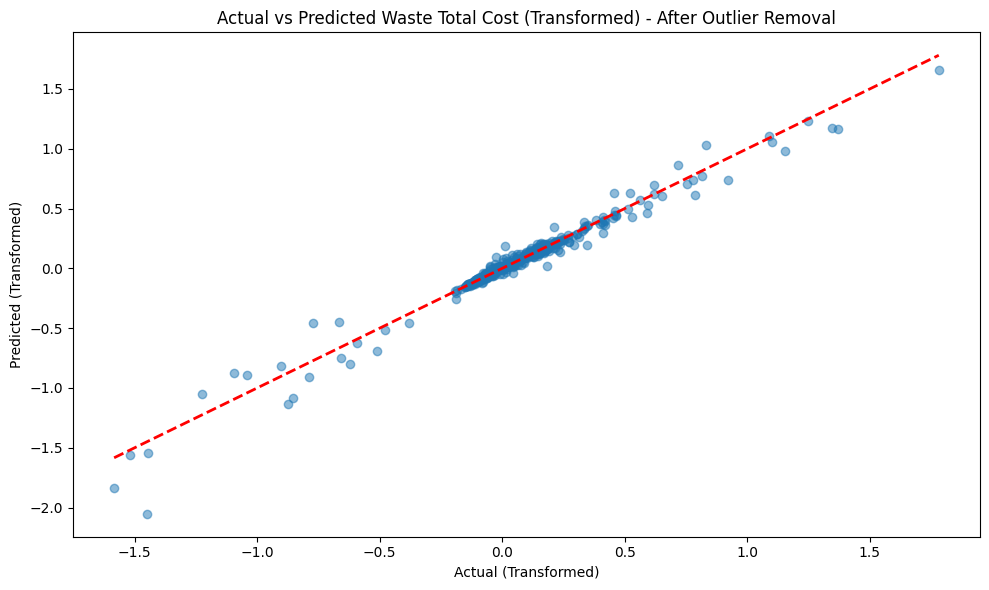

In [107]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual (Transformed)')
plt.ylabel('Predicted (Transformed)')
plt.title('Actual vs Predicted Waste Total Cost (Transformed) - After Outlier Removal')
plt.tight_layout()
plt.show()

In [108]:
# Inverse transform predictions and actual values for interpretability
y_pred_original = pt.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_test_original = pt.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate MSE and R2 in original scale
mse_original = mean_squared_error(y_test_original, y_pred_original)
r2_original = r2_score(y_test_original, y_pred_original)
print(f"Performance on original scale - MSE: {mse_original}, R2: {r2_original}")

Performance on original scale - MSE: 8536.183462244253, R2: 0.9661382046957402


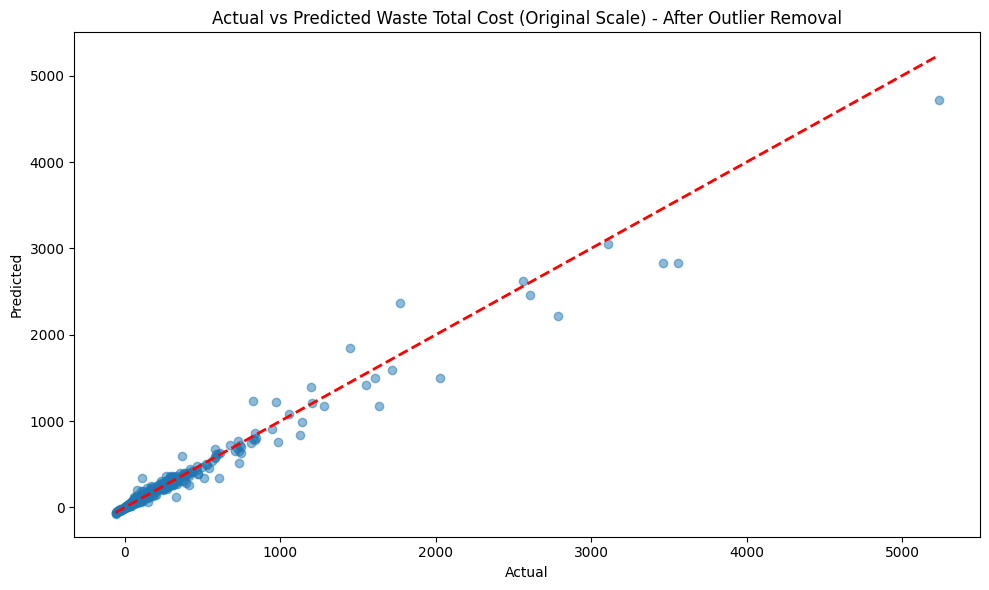

In [109]:
# Plot actual vs predicted values in original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Waste Total Cost (Original Scale) - After Outlier Removal')
plt.tight_layout()
plt.show()